In [2]:
# Reading in Multi-file netCDF impossible as file format is not accepted
import os
import pandas as pd
import numpy as np
import netCDF4 as nc

full_dataset = dict(time=[], cereal=[], nc=[])
path = 'data'
with os.scandir(path) as dir_data:
    for sub_dir_data in dir_data:
        for f in os.scandir(os.path.join(path, sub_dir_data.name)):
            path_f = os.path.join(path, sub_dir_data.name, f.name)
            time = int(f.name.split('_')[1][:4])
            full_dataset['time'].append(time)
            full_dataset['cereal'].append(sub_dir_data.name)
            full_dataset['nc'].append(nc.Dataset(path_f, 'r'))

df = pd.DataFrame(full_dataset)

(360, 720)
(360, 720)


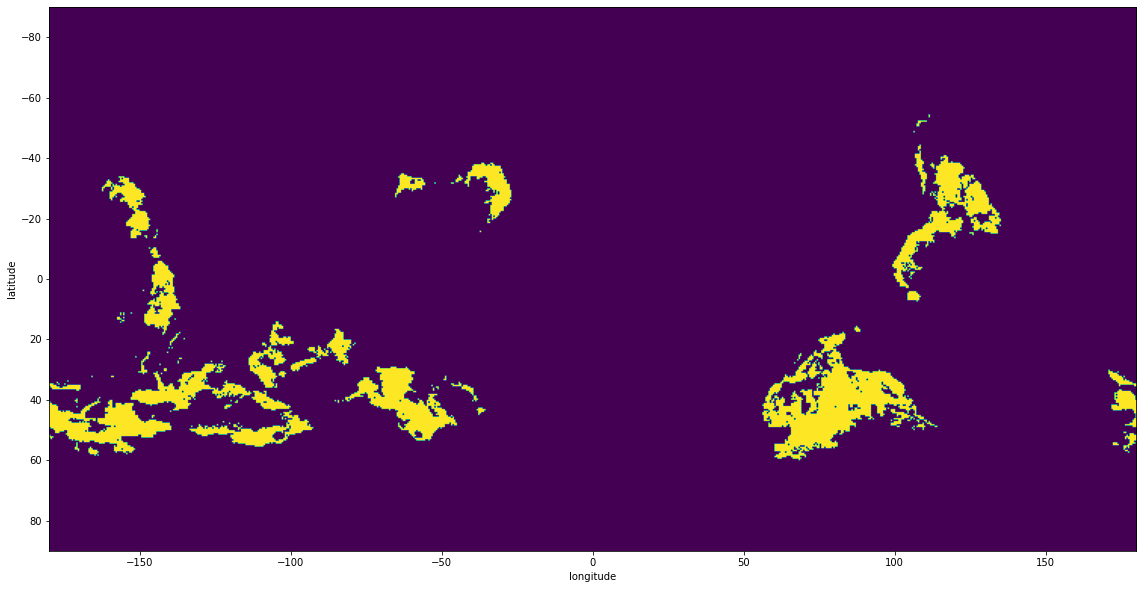

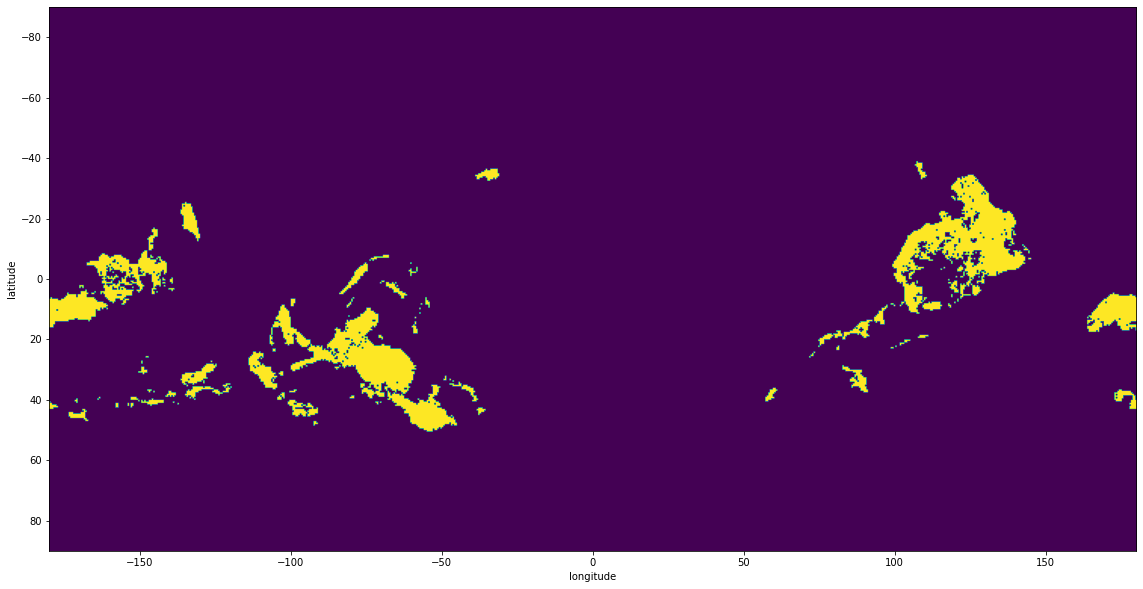

In [3]:
import matplotlib.pyplot as plt

def plot_var(ds):
    coordinate = ds['var'][:]
    print(coordinate.data.shape)
    plt.figure(figsize=(20,10))
    plt.imshow(coordinate.data, extent=[-180, 180, 90, -90])
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    
plot_var(df[(df['cereal'] == 'wheat') & (df['time'] == 1984)]['nc'].iat[0])
plot_var(df[(df['cereal'] == 'rice') & (df['time'] == 2000)]['nc'].iat[0])